# Transfer learning with TensorFlow on Food Vision mini


---




In this file, a Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only **10% percent of the data** is constructed and it covers the following topics:
1. Download and prepare **10% of the Food101 data** (10% of training data)
2. Train a **feature extraction transfer learning** model on 10% of the Food101 training data
3. **Fine-tuning** the feature extraction model
4. **Save and load** the trained model
5. **Evaluate the performance** of the Food Vision model trained on 10% of the training data

  *  Find the model's most wrong predictions


6. **Make predictions** with the Food Vision model on custom images of food

In [ ]:
import random
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Check GPU availablity
!nvidia-smi

Thu Jun  9 19:59:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import helper functions
!wget https://raw.githubusercontent.com/jinglan-shi/TensorFlow-Certificate-Preparation/main/extras/helper_functions.py

--2022-06-09 19:59:16--  https://raw.githubusercontent.com/jinglan-shi/TensorFlow-Certificate-Preparation/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17453 (17K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.04K  --.-KB/s    in 0s      

2022-06-09 19:59:17 (45.3 MB/s) - ‘helper_functions.py’ saved [17453/17453]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image, compare_historys, make_confusion_matrix, predict_and_visualize, load_and_prep_image

# Prepare dataset

In [ ]:
# Download dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-06-09 19:59:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   198MB/s    in 8.5s    

2022-06-09 19:59:34 (182 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Unzip the dataset
unzip_data('101_food_classes_10_percent.zip')

In [ ]:
# Get a view of the downloaded dataset
train_dir = '/content/101_food_classes_10_percent/train/'
test_dir = '/content/101_food_classes_10_percent/test/'

walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in

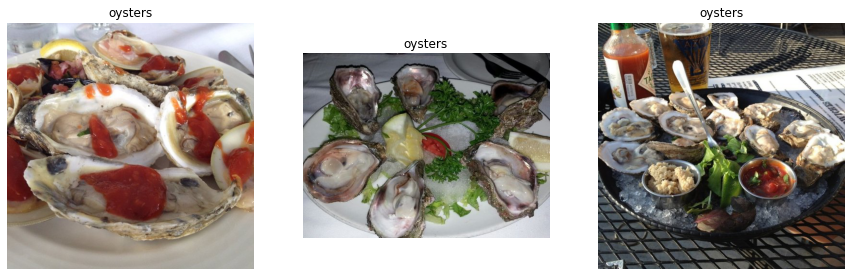

In [ ]:
# Visualize random image
view_random_image(target_class='oysters', directory=train_dir)

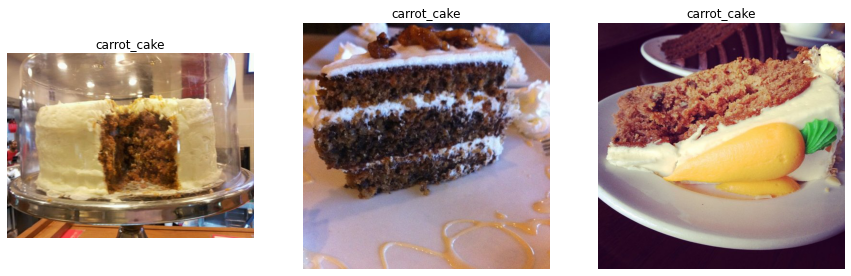

In [ ]:
view_random_image(target_class='carrot_cake', directory=test_dir)

## Setup data inputs

In [ ]:
# Prepare tf.Dataset object for model's use
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
train_data, test_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

In [ ]:
# Get a list of all the categories
class_names = train_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Visualize random image
for images, labels in train_data.take(1):
  image = images[0]
  label = labels[0]
  print(image)
  print(label)

tf.Tensor(
[[[128.06633  110.06633   96.06633 ]
  [158.75511  142.75511  127.75511 ]
  [154.37245  141.58673  126.01531 ]
  ...
  [133.13187  133.70334  128.70334 ]
  [ 62.755253  63.755253  57.755253]
  [ 45.178482  46.178482  40.178482]]

 [[124.341835 106.341835  92.341835]
  [148.50511  132.50511  117.505104]
  [146.86224  134.07654  118.505104]
  ...
  [158.99399  159.56546  153.77972 ]
  [ 62.72962   63.72962   57.72962 ]
  [ 74.73522   75.73522   69.73522 ]]

 [[117.01531   99.01531   85.01531 ]
  [137.83673  121.83675  106.83674 ]
  [151.87755  139.09183  123.52041 ]
  ...
  [138.41196  138.98343  133.1977  ]
  [ 59.94917   60.94917   54.520596]
  [ 72.663086  73.663086  65.663086]]

 ...

 [[139.092    130.092    121.092   ]
  [142.40802  133.40802  124.40802 ]
  [143.2755   134.48979  125.06122 ]
  ...
  [ 34.617382  40.525562  38.90818 ]
  [ 73.43381   82.43381   79.00528 ]
  [ 53.448303  62.87683   57.662567]]

 [[140.33157  131.33157  122.33158 ]
  [156.0613   147.0613   1

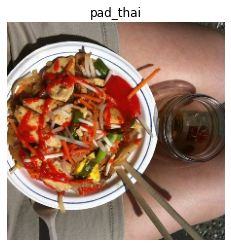

In [ ]:
plt.imshow(image/255.)
plt.title(class_names[tf.argmax(label).numpy()])
plt.axis('off')
plt.show()

## Configure datasets for better performance

In [ ]:
# Write a function to build flexible and efficient input pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_data = configure_for_performance(train_data)
test_data = configure_for_performance(test_data)

In [ ]:
train_data, test_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

# Train a model with transfer learning

## Create checkpoint callback

In [ ]:
checkpoint_path = '101_food_classes_10_percent_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True)

## Create data augmentation layer

In [ ]:
data_augmentation = Sequential([preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2)], name='data_augmentation')

## Create the headless base model for feature extraction

In [ ]:
# Setup the base mode and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile and fit the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_feature_extraction = model.fit(train_data,
                                      epochs=5,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 313ms/step - loss: 3.4618 - accuracy: 0.2484 - val_loss: 2.5896 - val_accuracy: 0.4481
Epoch 2/5
237/237 [==============================] - 57s 238ms/step - loss: 2.3384 - accuracy: 0.4635 - val_loss: 2.2213 - val_accuracy: 0.4767
Epoch 3/5
237/237 [==============================] - 52s 216ms/step - loss: 1.9763 - accuracy: 0.5370 - val_loss: 2.0294 - val_accuracy: 0.5101
Epoch 4/5
237/237 [==============================] - 49s 206ms/step - loss: 1.7630 - accuracy: 0.5750 - val_loss: 1.9544 - val_accuracy: 0.5093
Epoch 5/5
237/237 [==============================] - 46s 191ms/step - loss: 1.6022 - accuracy: 0.6084 - val_loss: 1.8850 - val_accuracy: 0.5169


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.7171 - accuracy: 0.5526


[1.7171076536178589, 0.5526336431503296]

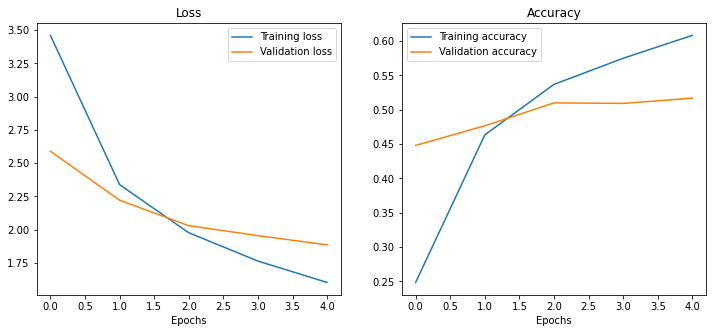

In [ ]:
# Plot loss curves
plot_loss_curves(history_feature_extraction)

## Fine-tuning the base model

In [ ]:
# Unfreese all of the layers in the base model
base_model.trainable = True

# Freeze layers except the last five
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile the model with lower learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# Check the layers' states
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Which layers are trainable in the base_model
for index, layer in enumerate(base_model.layers):
  print(index, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tuning_epochs = 10

history_fine_tuning = model.fit(train_data,
                              epochs=fine_tuning_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              initial_epoch=history_feature_extraction.epoch[-1])

Epoch 5/10
237/237 [==============================] - 54s 198ms/step - loss: 1.3567 - accuracy: 0.6495 - val_loss: 1.8731 - val_accuracy: 0.5151
Epoch 6/10
237/237 [==============================] - 44s 186ms/step - loss: 1.2312 - accuracy: 0.6801 - val_loss: 1.8945 - val_accuracy: 0.5164
Epoch 7/10
237/237 [==============================] - 41s 171ms/step - loss: 1.1452 - accuracy: 0.6919 - val_loss: 1.9208 - val_accuracy: 0.5082
Epoch 8/10
237/237 [==============================] - 39s 162ms/step - loss: 1.0783 - accuracy: 0.7197 - val_loss: 1.8710 - val_accuracy: 0.5212
Epoch 9/10
237/237 [==============================] - 38s 159ms/step - loss: 1.0211 - accuracy: 0.7333 - val_loss: 1.8792 - val_accuracy: 0.5222
Epoch 10/10
237/237 [==============================] - 39s 164ms/step - loss: 0.9750 - accuracy: 0.7374 - val_loss: 1.8809 - val_accuracy: 0.5249


In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 55s 70ms/step - loss: 1.6075 - accuracy: 0.5775


[1.607483148574829, 0.5774653553962708]

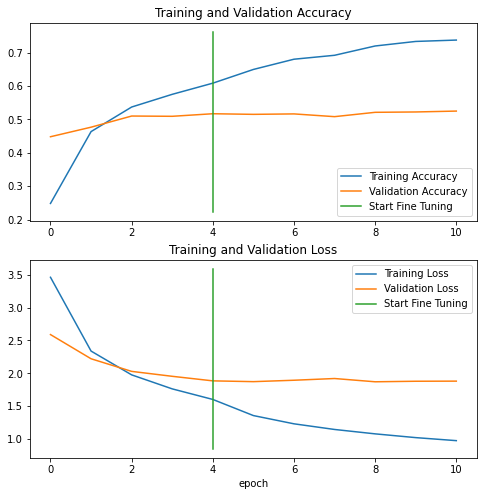

In [ ]:
# Compare the feature extraction and fine_tuning model
compare_historys(history_feature_extraction, history_fine_tuning)

In [ ]:
# Save and load model
model.save('fine_tuning_model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/fine_tuning_model.h5')

In [ ]:
# Evaluate the loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 57s 71ms/step - loss: 1.6075 - accuracy: 0.5775


[1.607483148574829, 0.5774653553962708]

In [ ]:
fine_tuning_results

[1.607483148574829, 0.5774653553962708]

# Evaluate the performance of the trained model

## Make predictions

In [ ]:
# Get the predictions (in probability values)
preds_probs = loaded_model.predict(test_data, verbose=1)
preds_probs

790/790 [==============================] - 61s 76ms/step


array([[2.4941052e-01, 1.6042207e-04, 2.3695581e-01, ..., 4.7907073e-05,
        1.8542847e-03, 4.4609636e-02],
       [9.4937378e-01, 6.2549638e-08, 1.5480891e-03, ..., 5.2045903e-04,
        1.6974789e-07, 7.0909337e-06],
       [1.5035807e-01, 4.8897993e-03, 3.5508458e-02, ..., 2.1062356e-03,
        6.3661090e-04, 2.9762797e-03],
       ...,
       [2.2331229e-05, 2.2680648e-03, 8.2050910e-08, ..., 7.8682060e-04,
        6.9189118e-05, 4.5152295e-01],
       [4.4264141e-04, 1.0129457e-02, 1.2022193e-03, ..., 1.2724326e-04,
        4.9599254e-04, 3.5538214e-01],
       [8.5647032e-03, 2.8314497e-03, 2.1383893e-03, ..., 6.5886695e-03,
        1.1729705e-04, 6.4527935e-01]], dtype=float32)

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
# Get a view of the first prediction
preds_probs[0], preds_probs[0].shape, sum(preds_probs[0])

(array([2.49410525e-01, 1.60422074e-04, 2.36955807e-01, 7.48357039e-08,
        2.28611793e-06, 1.79245171e-06, 9.58014498e-05, 1.06215894e-05,
        2.40289271e-02, 3.73850431e-04, 2.25724830e-06, 1.11179843e-05,
        2.83799041e-03, 8.50707124e-07, 5.50286546e-02, 1.55354128e-03,
        2.33126211e-05, 1.15557224e-03, 1.48668082e-03, 7.15785791e-06,
        3.61841317e-04, 8.21465583e-05, 1.74177723e-04, 6.86063140e-05,
        5.93278557e-04, 2.11925450e-04, 1.03327264e-04, 9.60043908e-05,
        1.07447520e-01, 2.73510511e-03, 1.49429377e-06, 5.44028997e-04,
        7.73941982e-04, 1.29405166e-07, 7.70930154e-03, 1.81325267e-05,
        3.14517441e-04, 2.50100304e-04, 3.22038047e-02, 2.93800058e-05,
        5.66927192e-05, 1.15671568e-03, 1.60755729e-03, 1.47674755e-05,
        4.23208439e-05, 3.35172626e-05, 6.95149822e-04, 4.50924301e-04,
        1.88812157e-06, 3.41829620e-02, 4.21642588e-04, 1.49602283e-05,
        9.51994434e-02, 7.93017726e-03, 8.09606572e-05, 1.308443

In [ ]:
# Get the human-readble prediction
pred = class_names[tf.argmax(preds_probs[0]).numpy()]
pred

'apple_pie'

In [ ]:
# Get the prediction classes of the whole test dataset
pred_classes = preds_probs.argmax(axis=1)
pred_classes

array([  0,   0,  14, ..., 100, 100, 100])

## Compare the predictions to the ground truth labels

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
len(test_data)

790

In [ ]:
test_data.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(101,), dtype=tf.float32, name=None))>

In [ ]:
# Unravel the test BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes[:10]

array([ 0,  0, 14,  8,  8, 78, 29, 46,  9,  0])

## Visualize by making a confusion matrix

In [ ]:
# Make sure the predictions are in the same order as the test labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5774653465346534

In [ ]:
loaded_model_results

[1.607483148574829, 0.5774653553962708]

In [ ]:
# Dose this metric come close to the model's evaluate results
np.isclose(sklearn_accuracy, loaded_model_results[1])

True

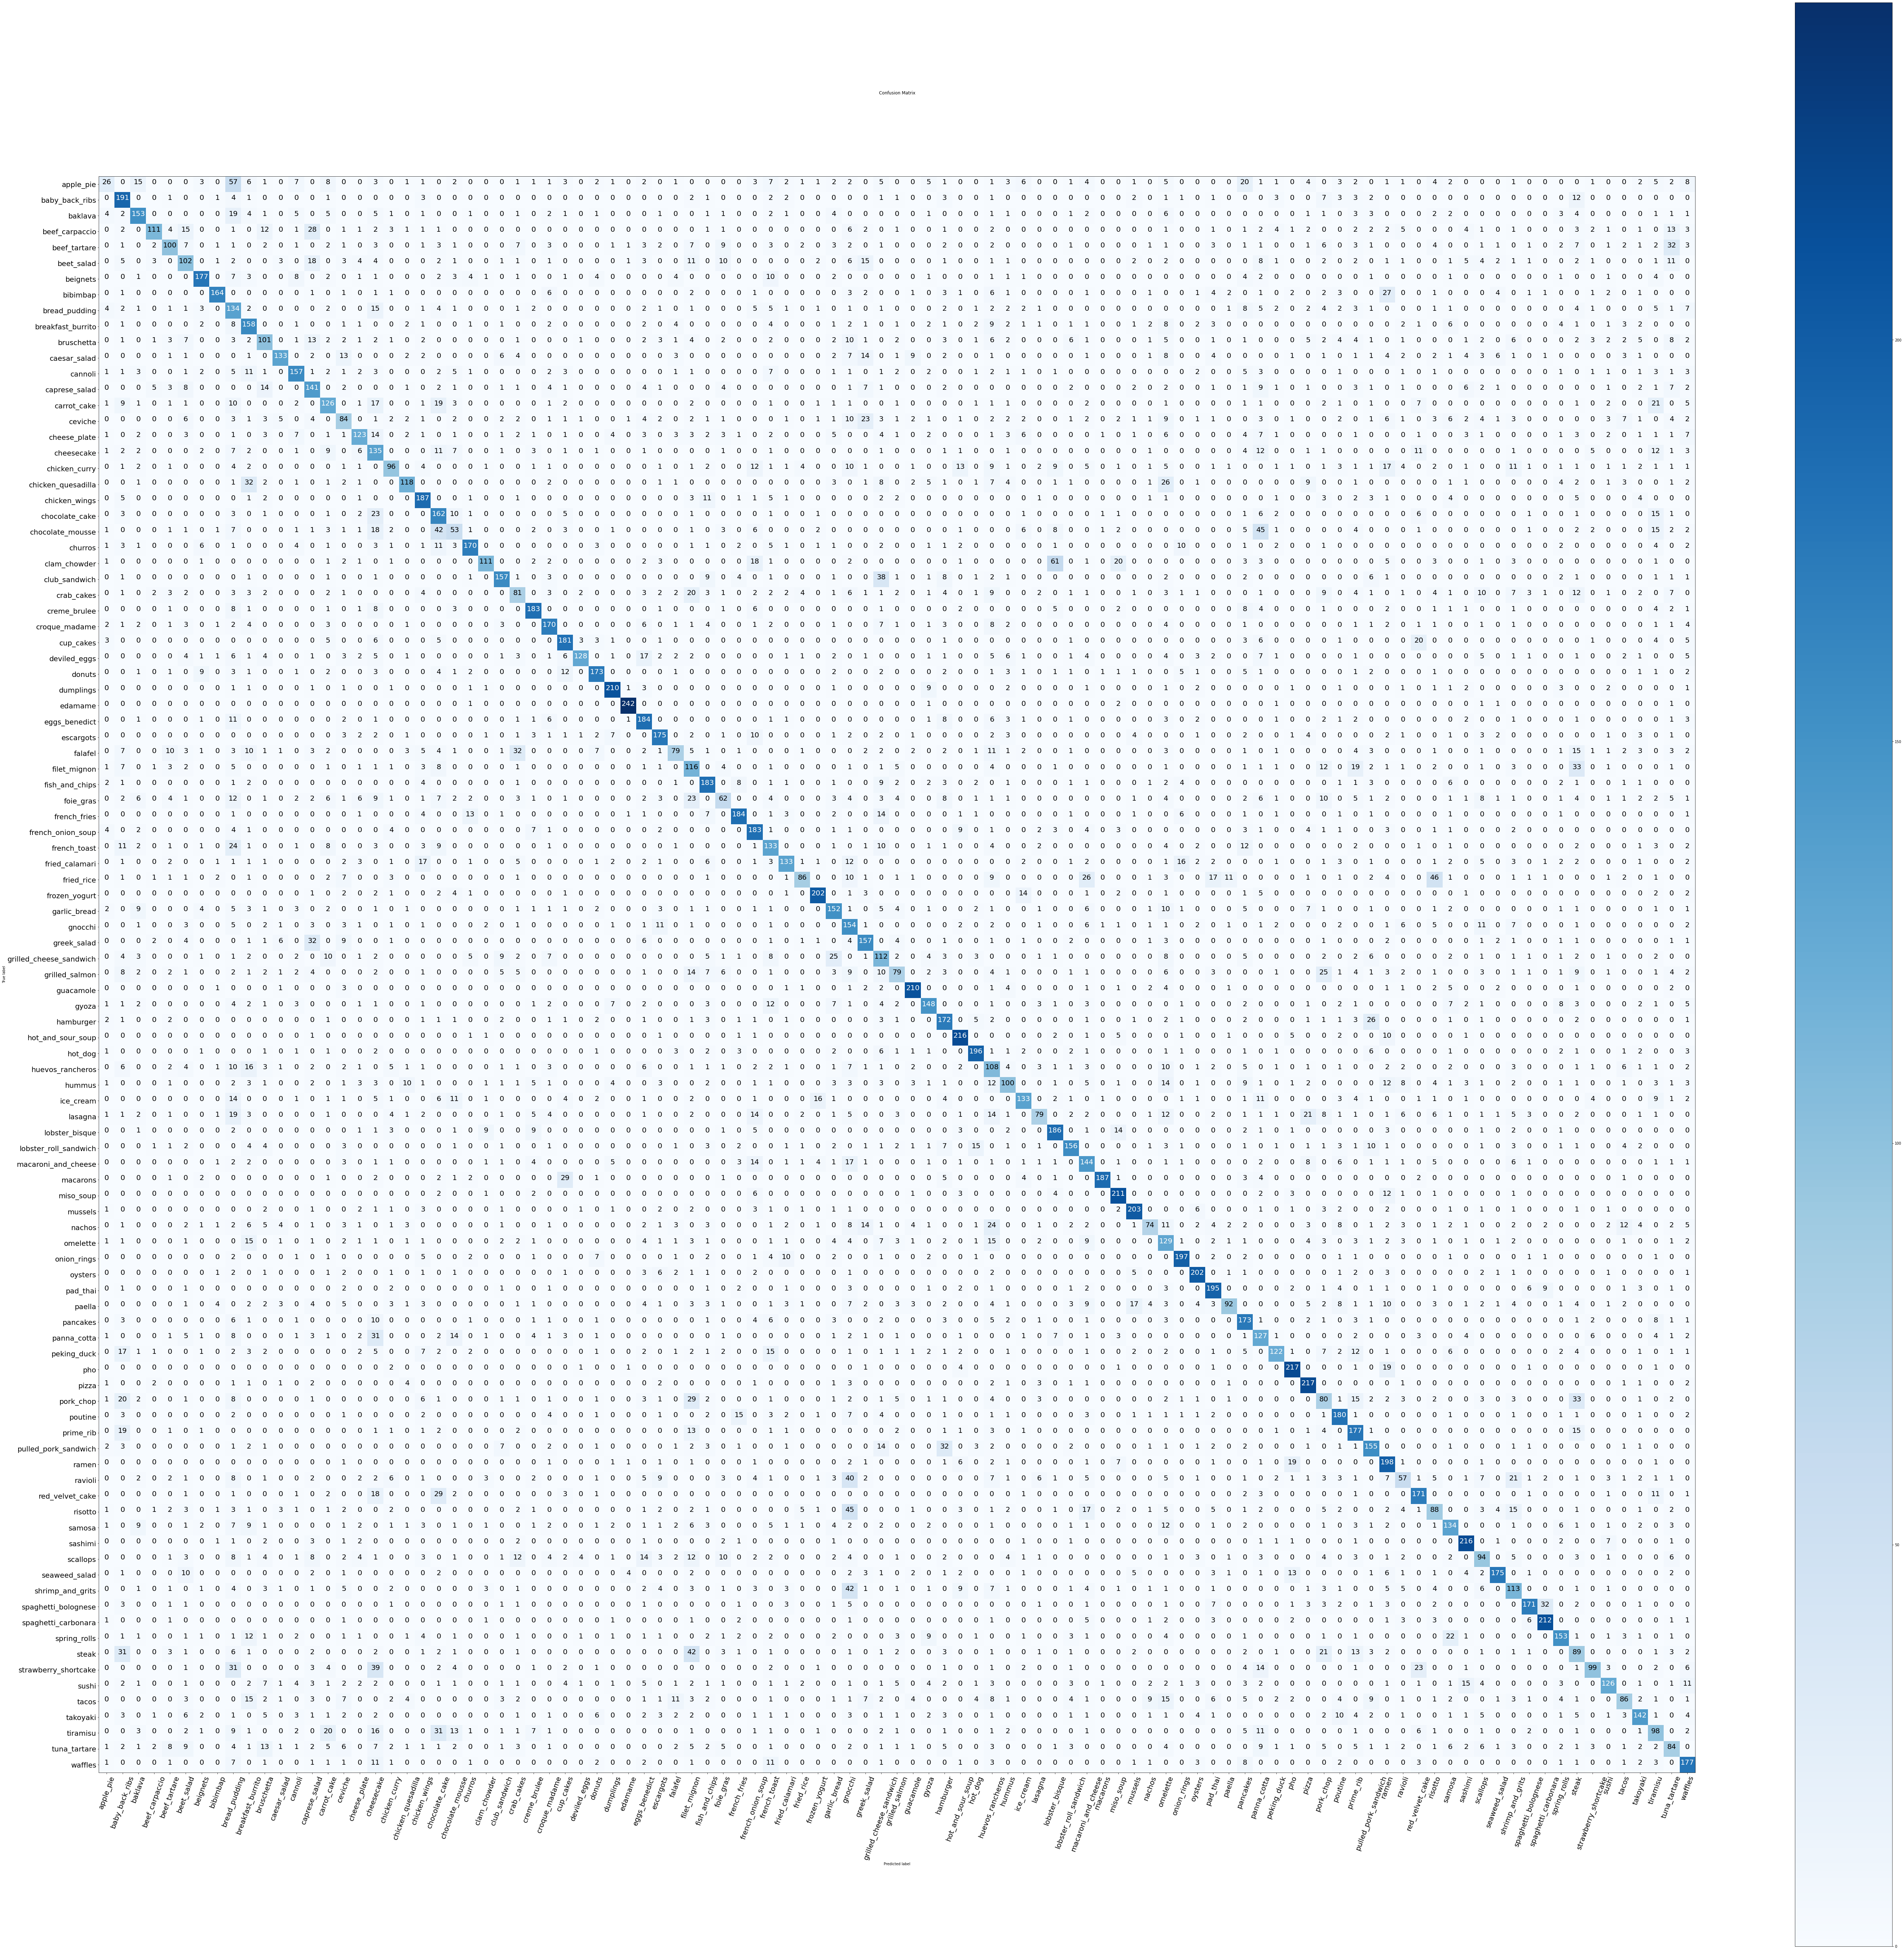

In [ ]:
# Make a confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Scikit-learn classfication report

In [ ]:
# Build a text report showing the main classification metrics
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.10      0.16       250
           1       0.48      0.76      0.59       250
           2       0.65      0.61      0.63       250
           3       0.82      0.44      0.58       250
           4       0.57      0.40      0.47       250
           5       0.43      0.41      0.42       250
           6       0.78      0.71      0.74       250
           7       0.89      0.66      0.75       250
           8       0.24      0.54      0.33       250
           9       0.43      0.63      0.51       250
          10       0.46      0.40      0.43       250
          11       0.79      0.53      0.64       250
          12       0.68      0.63      0.65       250
          13       0.46      0.56      0.51       250
          14       0.49      0.50      0.50       250
          15       0.40      0.34      0.36       250
          16       0.64      0.49      0.56       250
          17       0.29    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.1609907120743034,
  'precision': 0.3561643835616438,
  'recall': 0.104,
  'support': 250},
 '1': {'f1-score': 0.5922480620155038,
  'precision': 0.4835443037974684,
  'recall': 0.764,
  'support': 250},
 '10': {'f1-score': 0.42887473460721864,
  'precision': 0.45701357466063347,
  'recall': 0.404,
  'support': 250},
 '100': {'f1-score': 0.61139896373057,
  'precision': 0.5379939209726444,
  'recall': 0.708,
  'support': 250},
 '11': {'f1-score': 0.6363636363636365,
  'precision': 0.7916666666666666,
  'recall': 0.532,
  'support': 250},
 '12': {'f1-score': 0.6528066528066527,
  'precision': 0.6796536796536796,
  'recall': 0.628,
  'support': 250},
 '13': {'f1-score': 0.5081081081081081,
  'precision': 0.46229508196721314,
  'recall': 0.564,
  'support': 250},
 '14': {'f1-score': 0.499009900990099,
  'precision': 0.49411764705882355,
  'recall': 0.504,
  'support': 250},
 '15': {'f1-score': 0.3644251626898048,
  'precision': 0.3981042654028436,
  'recall': 0.336,
  

## Plot the f1-score of all classes

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

# Get the full f1-score dictionary
class_f1_scores

{'apple_pie': 0.1609907120743034,
 'baby_back_ribs': 0.5922480620155038,
 'baklava': 0.6283367556468172,
 'beef_carpaccio': 0.5751295336787565,
 'beef_tartare': 0.47058823529411764,
 'beet_salad': 0.4180327868852459,
 'beignets': 0.7405857740585773,
 'bibimbap': 0.7540229885057472,
 'bread_pudding': 0.33333333333333337,
 'breakfast_burrito': 0.5146579804560261,
 'bruschetta': 0.42887473460721864,
 'caesar_salad': 0.6363636363636365,
 'cannoli': 0.6528066528066527,
 'caprese_salad': 0.5081081081081081,
 'carrot_cake': 0.499009900990099,
 'ceviche': 0.3644251626898048,
 'cheese_plate': 0.5565610859728507,
 'cheesecake': 0.3802816901408451,
 'chicken_curry': 0.46376811594202894,
 'chicken_quesadilla': 0.5700483091787439,
 'chicken_wings': 0.6812386156648452,
 'chocolate_cake': 0.5094339622641509,
 'chocolate_mousse': 0.2585365853658536,
 'churros': 0.7280513918629551,
 'clam_chowder': 0.5692307692307692,
 'club_sandwich': 0.6709401709401709,
 'crab_cakes': 0.36160714285714285,
 'creme_bru

In [ ]:
# Trun f1-scores into dataframe for visualization
f1_scores = pd.DataFrame(data=class_f1_scores.items(),
                         columns=['class_names', 'f1-scores']).sort_values('f1-scores', ascending=False)
f1_scores

class_names  f1-scores
33              edamame   0.960317
63             macarons   0.842342
32            dumplings   0.834990
51            guacamole   0.833333
91  spaghetti_carbonara   0.826511
..                  ...        ...
39            foie_gras   0.314721
93                steak   0.314488
82              ravioli   0.294574
22     chocolate_mousse   0.258537
0             apple_pie   0.160991

[101 rows x 2 columns]

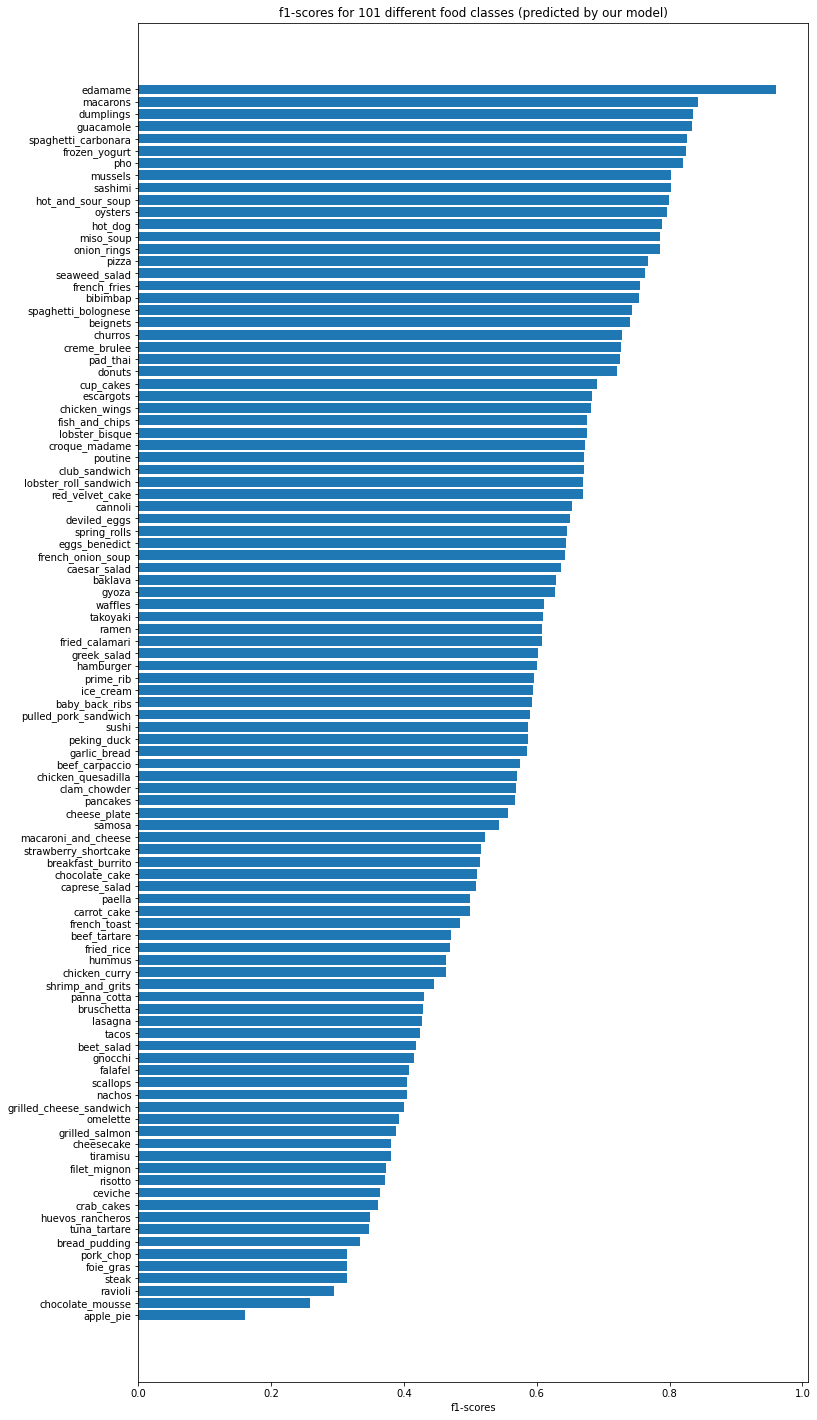

In [ ]:
# Make a bar plot for better visualization
plt.figure(figsize=(12, 25))
plt.barh(range(len(f1_scores)), f1_scores['f1-scores'].values)
plt.yticks(range(len(f1_scores)), labels=f1_scores['class_names'])
plt.xlabel('f1-scores')
plt.title('f1-scores for 101 different food classes (predicted by our model)')
plt.gca().invert_yaxis()
plt.show()

# Test model's performance on real-life images

## Make predictions on test images

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

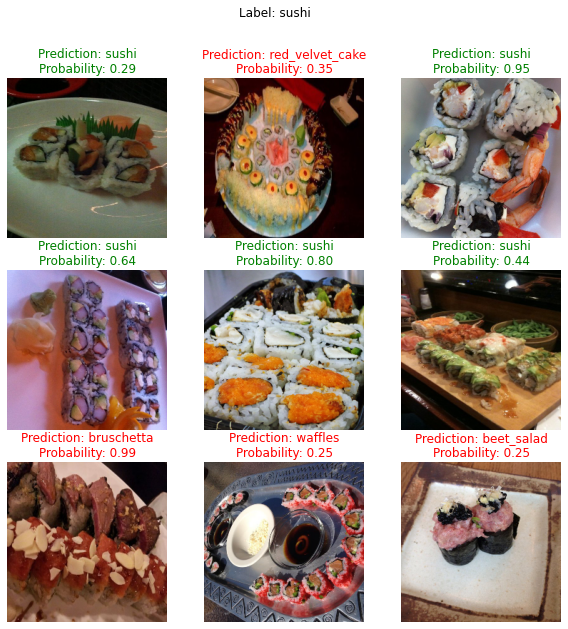

In [ ]:
predict_and_visualize(loaded_model, 'sushi', test_dir, class_names=class_names)

## Find the most wrong predictions

In [ ]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
preds_probs[:10]

array([[2.4941052e-01, 1.6042207e-04, 2.3695581e-01, ..., 4.7907073e-05,
        1.8542847e-03, 4.4609636e-02],
       [9.4937378e-01, 6.2549638e-08, 1.5480891e-03, ..., 5.2045903e-04,
        1.6974789e-07, 7.0909337e-06],
       [1.5035807e-01, 4.8897993e-03, 3.5508458e-02, ..., 2.1062356e-03,
        6.3661090e-04, 2.9762797e-03],
       ...,
       [2.0009290e-01, 2.3463328e-06, 1.6183631e-03, ..., 5.7886664e-02,
        3.5663118e-04, 1.3228340e-04],
       [1.0297068e-01, 5.0333847e-04, 1.7961438e-01, ..., 1.5154832e-04,
        7.3433206e-05, 4.5692941e-04],
       [4.5479646e-01, 3.5053247e-06, 1.4675277e-03, ..., 9.2043011e-03,
        1.1537379e-05, 2.8787570e-03]], dtype=float32)

In [ ]:
pred_classes[:10]

array([ 0,  0, 14,  8,  8, 78, 29, 46,  9,  0])

In [ ]:
# Create a dataframe of image filepaths, ground truth labels, predicted classes, max prediction probabilities
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0       0   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0      14   
3      b'/content/101_food_classes_10_percent/test/ap...       0       8   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname y_pred_classname  
0       0.249411        apple_pie        apple_pie  
1       0.949374        apple_pie        apple_pie  
2       0.215570        apple_pie      carrot_cake  
3       0.209135        apple_pie    bread_pudding  
4       0.300518        apple_pie    bread_pudding  
...          ...              ...              ...  
25245   0.983478          waffles          waffles  
25246   0.475554          waffles          waffles  
25247   0.451523          waffles          waffles  
25248   0.355382          waffles          waffles  
25249   0.645279          waffles          waffles  

[25250 rows x 6 columns]

In [ ]:
# Find all the wrong predictions
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0       0   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0      14   
3      b'/content/101_food_classes_10_percent/test/ap...       0       8   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname y_pred_classname  pred_correct  
0       0.249411        apple_pie        apple_pie          True  
1       0.949374        apple_pie        apple_pie          True  
2       0.215570        apple_pie      carrot_cake         False  
3       0.209135        apple_pie    bread_pudding         False  
4       0.300518        apple_pie    bread_pudding         False  
...          ...              ...              ...           ...  
25245   0.983478          waffles          waffles          True  
25246   0.475554          waffles          waffles          True  
25247   0.451523          waffles          waffles          True  
25248   0.355382          waffles          waffles          True  
25249   0.645279          waffles          waffles          True  

[25250 rows x 7 columns]

In [ ]:
# Sort the DataFrame to list the most wrong predictions first
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
11097  b'/content/101_food_classes_10_percent/test/fr...      44      70   
...                                                  ...     ...     ...   
1591   b'/content/101_food_classes_10_percent/test/be...       6      85   
7284   b'/content/101_food_classes_10_percent/test/cu...      29      21   
22095  b'/content/101_food_classes_10_percent/test/se...      88      65   
2619   b'/content/101_food_classes_10_percent/test/br...      10      13   
1041   b'/content/101_food_classes_10_percent/test/be...       4      10   

       pred_conf      y_true_classname y_pred_classname  pred_correct  
23631   0.999135  strawberry_shortcake  red_velvet_cake         False  
23797   0.999040                 sushi          sashimi         False  
17855   0.997771                paella          mussels         False  
15826   0.996577              macarons        cup_cakes         False  
11097   0.996026            fried_rice         pad_thai         False  
...          ...                   ...              ...           ...  
1591    0.961166              beignets           samosa         False  
7284    0.961067             cup_cakes   chocolate_cake         False  
22095   0.960364         seaweed_salad          mussels         False  
2619    0.960013            bruschetta    caprese_salad         False  
1041    0.960013          beef_tartare       bruschetta         False  

[100 rows x 7 columns]

## Visualize the images with wrong predictions but high preds_probs

In [ ]:
def plot_wrong_pred_img(dataframe, start_index, imgs_to_view=9):
  """
  Show the most wrong predictions on test images which has high prediction confidence.

  Args:
    dataframe (Pandas DataFrame): The dataframe of interest with images from which you make predictions on.
    start_index (int): The starting index of the dataframe's rows.
    imgs_to_view (int): The number of images you want to examine.
  """
  plt.figure(figsize=(15, 10))
  for i, row in enumerate(dataframe[start_index:start_index+imgs_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_conf, y_true_classname, y_pred_classname, _ = row
    plt.imshow(img/255.)
    plt.title(f'Actural: {y_true_classname}\nPrediction: {y_pred_classname}\nProbability: {pred_conf}')
    plt.axis('off')
  plt.tight_layout()

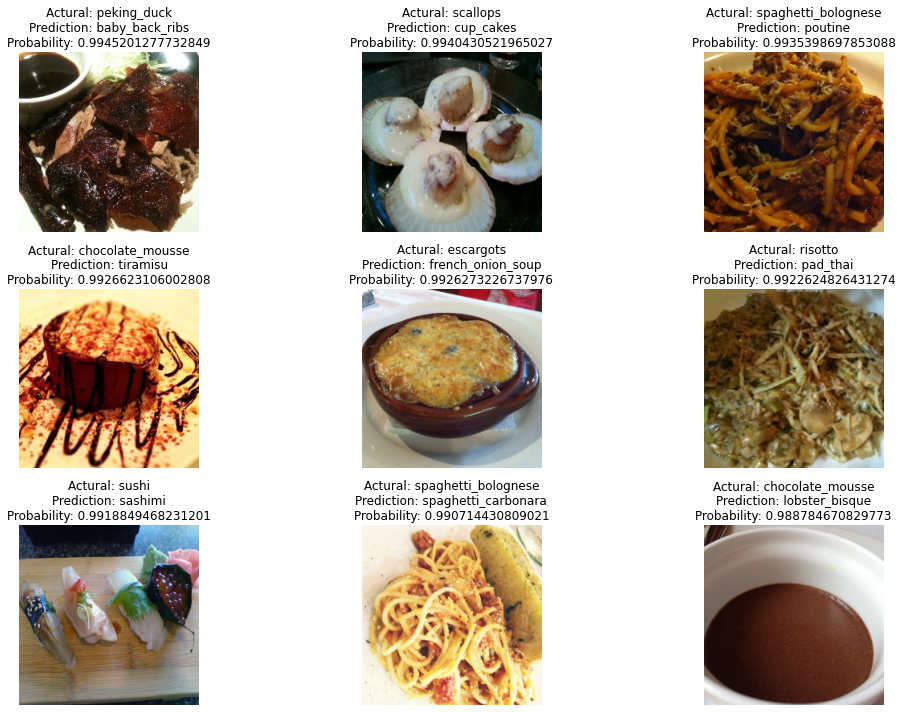

In [ ]:
plot_wrong_pred_img(dataframe=top_100_wrong, start_index=10, imgs_to_view=9)

## Make predictions on our own images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-06-09 20:18:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  44.5MB/s    in 0.3s    

2022-06-09 20:18:21 (44.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Unzip the downloaded file
unzip_data('custom_food_images.zip')

In [ ]:
# Get the filepath of the custom images
custom_food_images = ['/content/custom_food_images' + '/' + img_path for img_path in os.listdir('/content/custom_food_images')]
custom_food_images

['/content/custom_food_images/hamburger.jpeg',
 '/content/custom_food_images/ramen.jpeg',
 '/content/custom_food_images/chicken_wings.jpeg',
 '/content/custom_food_images/steak.jpeg',
 '/content/custom_food_images/sushi.jpeg',
 '/content/custom_food_images/pizza-dad.jpeg']

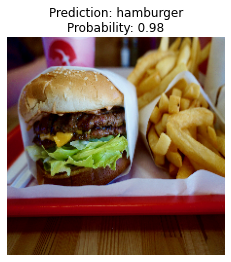

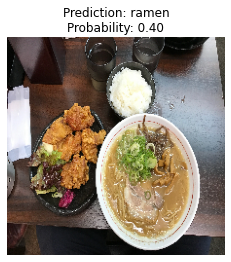

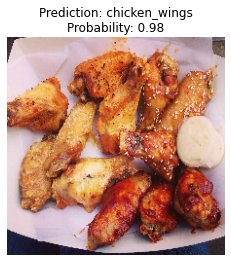

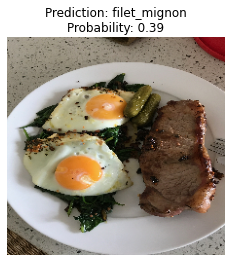

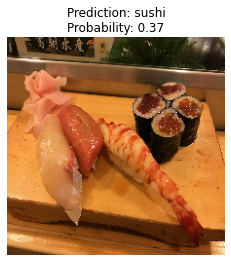

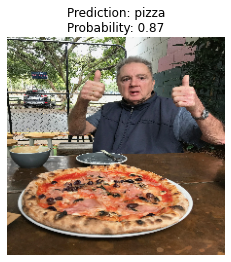

In [ ]:
# Make predictions
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_probs = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_probs.argmax()]

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'Prediction: {pred_class}\nProbability: {pred_probs.max():.2f}')
  plt.axis('off')